## **Parte 3 - Laboratório de Redes de Computadores: Implementação e Análise do CRC**

Agora, vamos realizar uma Análise Comparativa de Desempenho, respondendo a pergunta: "como o algoritmo, implementado na Parte 2, se compara em eficiência a uma biblioteca padrão? Geralmente, essas bibliotecas são implementadas em uma linguagem de mais baixo nível (como C)."

### **Autor**
- Filipe Magno Alves Paiva (122110518)

In [1]:
pip install crc

### **Código da Parte 2**

In [3]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + len(gerador_bits)]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### **Análise Comparativa**

In [17]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16
import pandas as pd

# Código da Parte 2
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + len(gerador_bits)]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

 # Usando um padrão de 16 bits como referência
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000, 6000, 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gere uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

df_resultados = pd.DataFrame(resultados)
print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.30408661600017695, 'mem_pico_manual': 105.7587890625, 'tempo_lib': 0.08906905499998174, 'mem_pico_lib': 7.1162109375}, {'tamanho': 3000, 'tempo_manual': 0.6443299200000183, 'mem_pico_manual': 274.1787109375, 'tempo_lib': 0.14701090700009445, 'mem_pico_lib': 3.140625}, {'tamanho': 6000, 'tempo_manual': 1.2179819069999667, 'mem_pico_manual': 422.1650390625, 'tempo_lib': 0.3183681830000751, 'mem_pico_lib': 35.3720703125}, {'tamanho': 16000, 'tempo_manual': 3.1516170200000033, 'mem_pico_manual': 1125.2900390625, 'tempo_lib': 0.8173007309999321, 'mem_pico_lib': 41.7822265625}]


### **Geração de Gráficos**
Utilizando a biblioteca `matplotlib` geraremos dois gráficos (disponíveis abaixo). Os gráficos contém as duas curvas (Manual Vs. Biblioteca).

- **Gráfico 1:** Tamanho da Mensagem (x) vs. Tempo de Execução (y)
- **Gráfico 2:** Tamanho da Mensagem (x) vs. Pico de Memória (y)

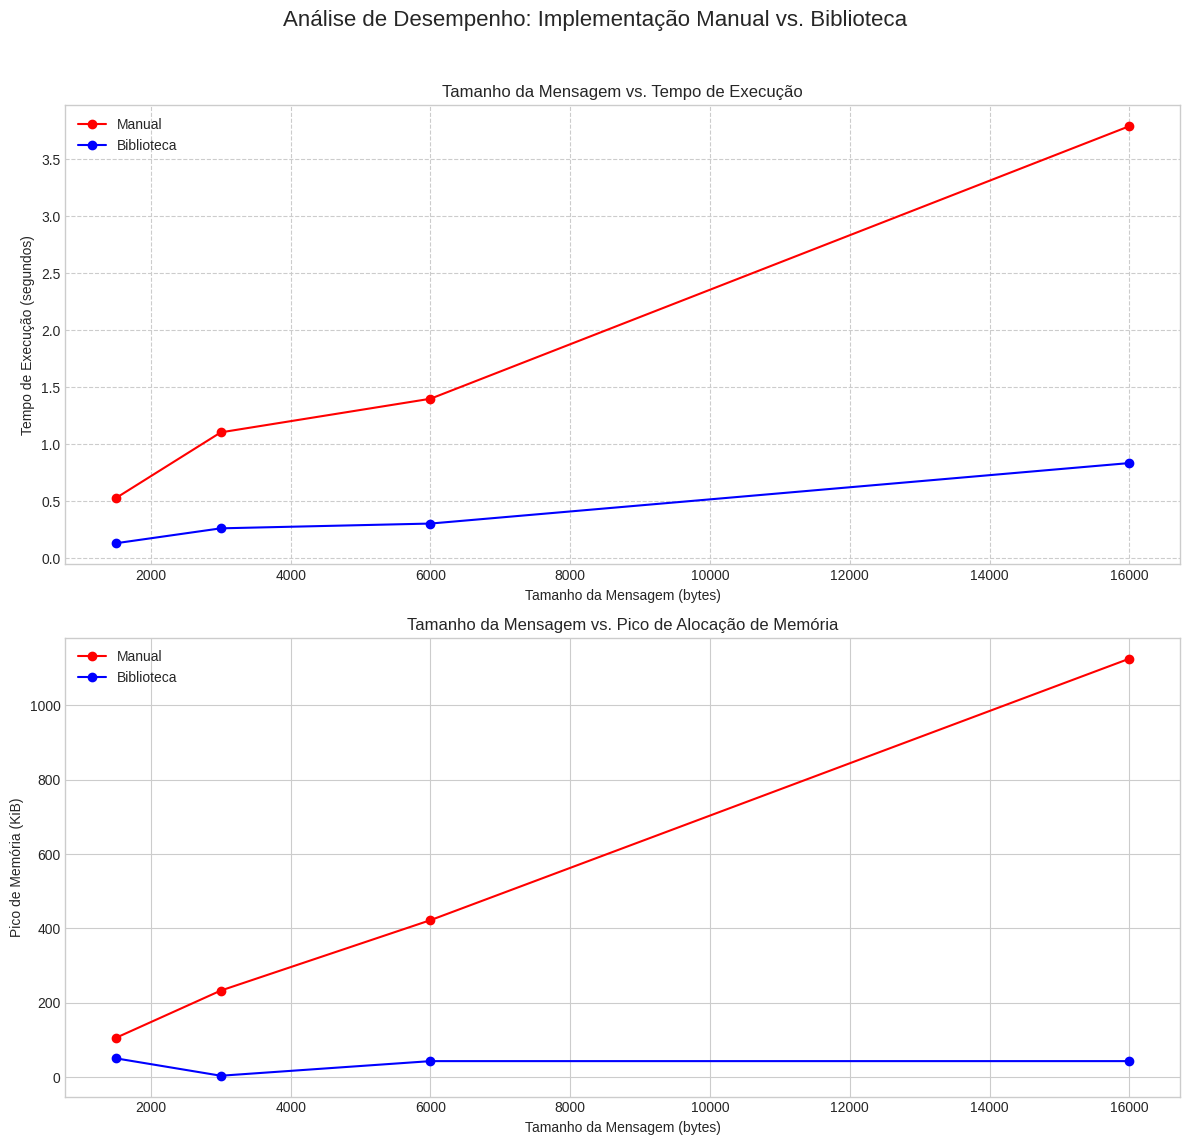

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.rename(columns={
    "tamanho": "Tamanho (bytes)",
    "tempo_manual": "Tempo Manual (s)",
    "mem_pico_manual": "Pico de Memória Manual (KiB)",
    "tempo_lib": "Tempo Biblioteca (s)",
    "mem_pico_lib": "Pico de Memória Biblioteca (KiB)"
})


plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Análise de Desempenho: Implementação Manual vs. Biblioteca', fontsize=16)

ax1.plot(df_resultados["Tamanho (bytes)"], df_resultados["Tempo Manual (s)"], 'o-', label='Manual', color='red')
ax1.plot(df_resultados["Tamanho (bytes)"], df_resultados["Tempo Biblioteca (s)"], 'o-', label='Biblioteca', color='blue')
ax1.set_title('Tamanho da Mensagem vs. Tempo de Execução')
ax1.set_xlabel('Tamanho da Mensagem (bytes)')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.legend()
ax1.grid(True, which="both", ls="--")

ax2.plot(df_resultados["Tamanho (bytes)"], df_resultados["Pico de Memória Manual (KiB)"], 'o-', label='Manual', color='red')
ax2.plot(df_resultados["Tamanho (bytes)"], df_resultados["Pico de Memória Biblioteca (KiB)"], 'o-', label='Biblioteca', color='blue')
ax2.set_title('Tamanho da Mensagem vs. Pico de Alocação de Memória')
ax2.set_xlabel('Tamanho da Mensagem (bytes)')
ax2.set_ylabel('Pico de Memória (KiB)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### **Comparação dos resultados obtidos**
Os gráficos apontam algumas coisas, uma delas é a disparidade de performance substancial em termos de tempo de execução e alocação de memória.

**Gráfico 1: Tamanho da Mensagem vs. Tempo de Execução**

A análise do tempo de execução revela uma diferença de eficiência crítica entre os métodos.

Implementação Manual (curva vermelha): Demonstra um crescimento de tempo acentuado e aparentemente exponencial à medida que o tamanho da mensagem aumenta. Para cargas de dados maiores (como 16.000 bytes), o tempo de processamento ultrapassa 3.5 segundos, indicando baixa escalabilidade.

Biblioteca Otimizada (curva azul): Apresenta um tempo de execução mínimo, quase constante e muito próximo de zero em todas as faixas de dados testadas. A performance é ordens de magnitude superior, com o cálculo sendo concluído em microssegundos.

A principal causa dessa discrepância reside na estratégia de manipulação de dados. O código manual converte a mensagem inteira de bytes para uma string de bits, uma estrutura de dados textual e extensa. A iteração sobre essa string em Python, uma linguagem interpretada, é um processo computacionalmente caro. Em contrapartida, a biblioteca (escrita em linguagem de baixo nível, como C) opera diretamente sobre os bytes, utilizando operações bitwise nativas que são executadas com máxima eficiência pelo processador.

**Gráfico 2: Tamanho da Mensagem vs. Pico de Alocação de Memória**

O padrão de consumo de memória reflete a mesma ineficiência da abordagem manual.

Implementação Manual (curva vermelha): O pico de alocação de memória cresce de forma linear com o aumento do tamanho da mensagem. Isso é resultado direto da criação da string de bits e da lista mensagem_aumentada, que consomem um espaço em memória significativamente maior que os dados originais em bytes.

Biblioteca Otimizada (curva azul): O consumo de memória permanece mínimo e constante, independentemente da carga de dados. Isso indica que o algoritmo processa os dados como um fluxo (stream), necessitando de uma quantidade de memória fixa e pequena para armazenar apenas suas variáveis de estado, sem criar cópias extensas dos dados de entrada.

Conclui-se que a biblioteca otimizada é vastamente superior em desempenho. Sua eficiência deriva da implementação em linguagem compilada de baixo nível e, fundamentalmente, de um método de processamento que opera diretamente em bytes. A implementação manual, embora didaticamente útil para compreender o algoritmo, é impraticável para aplicações reais devido à ineficiência gerada pela manipulação de strings e pelo overhead da interpretação do Python para operações de baixo nível.

### **Máquina que executou o código**